#MP4

In this assignment you will be performing Semantic Segmentation. We've provided the dataset and some helper code to guide you along.

Reminders:
- When first getting your code to run do not use GPU as this will exhaust your colab resources
- When you're ready to properly test your models, make sure you are connected to a GPU runtime as this does significantly speeds up execution
    - To change your runtime do: **Runtime** --> **Change runtime type** --> under **Hardware accelerator** select **GPU**
    - Note that changing runtime resets your kernel (meaning you will need to rerun cells and local variables will be lost)
    - It also sets this new runtime as the default when you return to this notebook later
- Do not start last minute, these models do take some time to train
- Loading the data takes some time, you should only have to do this once

## Accessing the data

There are multiple ways to work with data in colab.
See this [Colab notebook](https://colab.research.google.com/notebooks/io.ipynb) or this [StackOverflow post](https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive) for more details.

Once you've mounted your drive you can see your entire drive file structure by clicking the "Files" tab on the left.

**If you wish to work locally you can ignore the first two cells, but you will still need to set the appropriate path for your dataset**

In [ ]:
import glob
import os
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, average_precision_score
import random

from PIL import Image
import torch
from torch import nn
from torch.utils import data
import torchvision
from torchvision import models
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim

DATASET_PATH = '/mnt/sdc2/data/CS498_Data/sbd/'

## Dataset (Q1)

Here we define a class (pytorch Dataset) for accessing data. This allows us to perform transformations on the data (data augmentation) as we access it. Pytorch dataloaders take in a dataset and conventiently deal with the overhead of looping through it in batches. Creating such datasets/loaders significantly simplifies our training code later on.

**PDF: In your pdf visualize the same image (your choice which) a couple times to demonstrate your transformations**



In [ ]:
class SegmentationDataset(data.Dataset):
    """
    Data loader for the Segmentation Dataset. If data loading is a bottleneck, 
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as 
    to limit delays due to disk reads.
    """
    def __init__(self, split="train", data_dir=DATASET_PATH, transform=False):
        assert(split in ["train", "val", "test"])
        self.img_dir = os.path.join(data_dir, split)
        self.classes = []
        with open(os.path.join(data_dir, 'classes.txt'), 'r') as f:
            for l in f:
                self.classes.append(l.rstrip())
        self.n_classes = len(self.classes)
        self.split = split
        self.data = glob.glob(self.img_dir + '/*.jpg') 
        self.data = [os.path.splitext(l)[0] for l in self.data]
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = Image.open(self.data[index] + '.jpg')
        gt = Image.open(self.data[index] + '.png')

        # Question 1: data augmentation
        # hint: how does transforming the image affect the ground truth?
        # Note: your transformation should not change the image dimensions    
        if self.transform:
            ow, oh = img.size
            l, r, h, w = transforms.RandomCrop.get_params(img, output_size=(128,128))
            img = transforms.Resize(size=(oh,ow))(TF.crop(img, l, r, h, w))
            gt = transforms.Resize(size=(oh,ow))(TF.crop(gt, l, r, h, w))
            
            if torch.rand(1) > 0.5:
                img = TF.hflip(img)
                gt = TF.hflip(gt)

        img = transforms.ToTensor()(img)
        gt = torch.squeeze(transforms.PILToTensor()(gt)).type(torch.LongTensor)
        return img, gt

In [ ]:
dataset = SegmentationDataset(split="train", data_dir=DATASET_PATH, transform=True)

In [ ]:
# TODO: set the batch size, when running experiments later you should try different batch sizes
training_batch_size = 32
dataloader = data.DataLoader(dataset, batch_size=training_batch_size, shuffle=True, num_workers=2, drop_last=True)

In [ ]:
val_dataset = SegmentationDataset(split="val", data_dir=DATASET_PATH, transform=False)

In [ ]:
val_dataloader = data.DataLoader(val_dataset, batch_size=training_batch_size, shuffle=False, num_workers=2, drop_last=False)

In [ ]:
def view_image(idx):
    img = dataset[idx]
    _, axes = plt.subplots(1,2)
    axes[0].imshow(np.swapaxes(np.swapaxes(img[0], 0, 2), 0, 1))
    axes[1].imshow(img[1])
    plt.show()

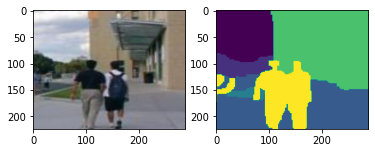

In [ ]:
# You might want to look at a bunch of different images to get a feel for your data
view_image(random.randint(0, len(dataset)))

## Simple Baseline (Q2)

This is a trivial semantic segmentor. For each pixel location it computes the 
distribution of the class label in the training set and uses that as the 
prediction. In other words, if a pixel is "sky" half the time and "water" the other half in the training data, you should label it as [0.5,0,0,0,0.5,0,0,0,0].

**PDF: in your pdf report the evaluation metrics (from the next question) for this simple baseline. Also visualize the output image of simple_predict (since simple_predict outputs the same segmentation regardless of input you can just report a single image)**

In [ ]:
# Question 2
# Output shape: (num_classes, 224, 288)
def simple_train(train_dataset):
    """
    Implementation of a trivial segmentor where we compute the
    class frequency at every pixel across our training data
    """
    model = np.zeros((train_dataset.n_classes, 224, 288)) / train_dataset.n_classes
    for img, gt in train_dataset:
        for i in range(train_dataset.n_classes):
            gt_ret = np.zeros_like(gt)
            y, x = np.where(gt == i)
            gt_ret[y,x] = 1
            model[i, :, :] += np.array(gt_ret)
    return model

# Output:
#   gt: the ground truth segmentation, shape (dataset_size, 1, 224, 288)
#   preds: the predicted segmentation class probabilities, shape (dataset_size, 9, 224, 288) 
def simple_predict(dataloader, model):
    gts, preds = [], []

    ### Calculate Pixel-Wise Class Probabilities ###
    model /= len(dataloader.dataset)
    for i , batch in enumerate(tqdm(dataloader)):
        images = batch[0]
        labels = batch[1]
        for j in range(len(images)):
            gts.append(np.array(labels[j]))
            preds.append(model)
    return np.array(gts), np.array(preds), list(dataloader.dataset.classes)

In [ ]:
# our "model" is class frequency, train it then make predictions for the validation set 
class_freq = simple_train(dataset)
gts, preds, classes = simple_predict(val_dataloader, class_freq)

  0%|          | 0/3 [00:00<?, ?it/s]

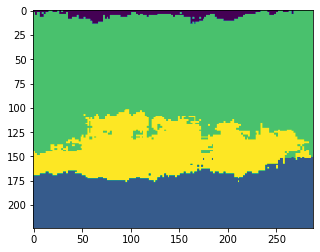

In [ ]:
# visualize the output segmentation prediction
plt.imshow(np.argmax(preds[0], axis=0))

## Evaluation Metrics (Q3)

We've implemented mean average precision. Your job is to compute the confusion matrix and IoU for a set of predictions. Namely, fill in the compute_confusion_matrix function.

The **(i,j)**th entry of a confusion matrix computes the number of observations known to be in group **i** and predicted to be in group **j**. You can use [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) as a reference and sanity check.

IoU is the intersection of the predicted and ground truth segmentation masks divided by their union. Think how these values are related to what you've already computed in the confusion matrix. 

In [ ]:
def segmentation_eval(gts, preds, classes, plot_file_name):
    """
    @param    gts               numpy.ndarray   ground truth labels
    @param    preds             numpy.ndarray   predicted labels
    @param    classes           string          class names
    @param    plot_file_name    string          plot file names
    """
    ious, counts = compute_confusion_matrix(gts, preds)
    aps = compute_ap(gts, preds)
    plot_results(counts, ious, aps, classes, plot_file_name)
    for i in range(len(classes)):
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
    print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))
    return aps, ious

def plot_results(counts, ious, aps, classes, file_name):
    fig, ax = plt.subplots(1,1)
    conf = counts / np.sum(counts, 1, keepdims=True)
    conf = np.concatenate([conf, np.array(aps).reshape(-1,1), 
                           np.array(ious).reshape(-1,1)], 1)
    conf = conf * 100.
    sns.heatmap(conf, annot=True, ax=ax, fmt='3.0f') 
    arts = [] 
    # labels, title and ticks
    _ = ax.set_xlabel('Predicted labels')
    arts.append(_)
    _ = ax.set_ylabel('True labels')
    arts.append(_)
    _ = ax.set_title('Confusion Matrix, mAP: {:5.1f}, mIoU: {:5.1f}'.format(
      np.mean(aps)*100., np.mean(ious)*100.))
    arts.append(_)
    _ = ax.xaxis.set_ticklabels(classes + ['AP', 'IoU'], rotation=90)
    arts.append(_)
    _ = ax.yaxis.set_ticklabels(classes, rotation=0)
    arts.append(_)
    # fig.savefig(file_name, bbox_inches='tight')
    plt.show()

def compute_ap(gts, preds):
    aps = []
    for i in range(preds.shape[1]):
        ap, prec, rec = calc_pr(gts == i, preds[:,i:i+1,:,:])
        aps.append(ap)
    return aps

def calc_pr(gt, out, wt=None):
    gt = gt.astype(np.float64).reshape((-1,1))
    out = out.astype(np.float64).reshape((-1,1))
    tog = np.concatenate([gt, out], axis=1)*1.
    ind = np.argsort(tog[:,1], axis=0)[::-1]
    tog = tog[ind,:]
    cumsumsortgt = np.cumsum(tog[:,0])
    cumsumsortwt = np.cumsum(tog[:,0]-tog[:,0]+1)
    prec = cumsumsortgt / cumsumsortwt
    rec = cumsumsortgt / np.sum(tog[:,0])
    ap = voc_ap(rec, prec)
    return ap, rec, prec

def voc_ap(rec, prec):
    rec = rec.reshape((-1,1))
    prec = prec.reshape((-1,1))
    z = np.zeros((1,1)) 
    o = np.ones((1,1))
    mrec = np.vstack((z, rec, o))
    mpre = np.vstack((z, prec, z))

    mpre = np.maximum.accumulate(mpre[::-1])[::-1]
    I = np.where(mrec[1:] != mrec[0:-1])[0]+1;
    ap = np.sum((mrec[I] - mrec[I-1])*mpre[I])
    return ap
    
# Question 3: compute the confusion matrix and IoU metrics for each class
# Hint: once you've computed the confusion matrix, IoU is easy
# Note: preds contains class probabilities, convert this to a class prediction
def compute_confusion_matrix(gts, preds):
    # Your code
    IoU = np.zeros((9))
    conf = np.eye(9)
    prediction = preds.argmax(axis=1)
    for i in range(len(prediction)):
        gt = gts[i].flatten()
        pred = prediction[i].flatten()
        for j in range(len(gt)):
            gt_pixel = int(gt[j])
            pred_pixel = int(pred[j])
            conf[gt_pixel, pred_pixel] += 1

    for i in range(len(conf)):
        intersection = conf[i, i]
        union = conf[i, :].sum()
        IoU[i] = intersection / union
    return IoU, conf

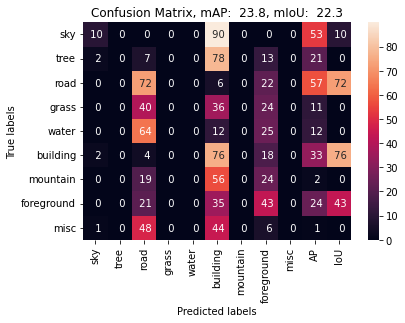

                 sky: AP: 0.53, IoU: 0.10
                tree: AP: 0.21, IoU: 0.00
                road: AP: 0.57, IoU: 0.72
               grass: AP: 0.11, IoU: 0.00
               water: AP: 0.12, IoU: 0.00
            building: AP: 0.33, IoU: 0.76
            mountain: AP: 0.02, IoU: 0.00
          foreground: AP: 0.24, IoU: 0.43
                misc: AP: 0.01, IoU: 0.00
                mean: AP: 0.24, IoU: 0.22


In [ ]:
# Evaluate our trivial segmentor
aps, ious = segmentation_eval(gts, preds, classes, 'cs498-simple-train.png')

## Loss function (Q4)

Implement the weighted cross entropy loss. 

You may not call nn.CrossEntropy but can use it as a good reference and sanity check.

**PDF: in your pdf please describe the cross entropy loss. Also explain the purpose of using a weighted loss.**

In [ ]:
def cross_entropy_criterion(predictions, labels, weights=None, smoothing=1e-7):
    labels = torch.permute(F.one_hot(torch.squeeze(labels), num_classes=9),(0,3,1,2))
    if weights is not None:
        weights = F.softmax(weights, dim=0)
        assert torch.is_tensor(weights) is True
        image_dim = predictions.shape[-2:]
        image_flatten_dim = image_dim[0] * image_dim[1]
        weights = weights.repeat(image_flatten_dim, 1).T.reshape(predictions.shape[1:])
    
    else:
        weights = torch.ones_like(predictions)
    predictions = predictions * weights
    predictions = F.softmax(predictions, dim=1)
    total_loss = ((-torch.log(predictions + smoothing) * labels)).sum(dim=1).mean()
    return total_loss

## Training loop (Q5)

Fill in the training loop. We've provided validation code as well as skeleton code for training.

Keep in mind that you need to move data onto the device (GPU) as you cycle through the dataloader

While we've provided you with a skeleton to fill in, you should feel free to modify the visualization code for debugging purposes. For example you might want to print out the loss each iteration instead of once per epoch. Or you might want to compute validation accuracy metrics (like IoU) instead of just validation loss.

**PDF: in your pdf please describe why it is important to consider both validation and training losses simultaneously. When loss stops decreasing, can we change something about the training parameters to continue improving the model?**

In [ ]:
def validate_model(val_loader, model, classes, device, show_matrix=False):
    preds = np.array([]).reshape(0,9,224,288)
    gts = np.array([]).reshape(0,224,288)
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)

            outputs = model(inputs).cpu().numpy()
            preds = np.concatenate([preds, outputs], axis=0)
            gts = np.concatenate([gts, labels.numpy()], axis=0)
            
            print("Validating...{}\r".format(100.0*len(preds)/len(val_loader)), end="")

    if show_matrix:
        aps, ious = segmentation_eval(gts, preds, classes, 'cs543-simple-val_3.pdf')
    else:
        ious, counts = compute_confusion_matrix(gts, preds)
        aps = compute_ap(gts, preds)
        for i in range(len(classes)):
            print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))

    return preds, gts

def training_loop(model, optimizer, trainloader, device="cuda:0", criterion=None,
                  class_weights=None, valloader=None, epochs=30):

    train_loss_over_epochs = []
    val_loss_over_epochs = []
    plt.ioff()
    fig = plt.figure()
    
    if class_weights is None:
        class_weights = torch.ones(9).to(device)
    if criterion is None: 
        ### IF NOT GIVEN CROSSENTROPY FUNCTION USE PYTORCH METHOD ###
        criterion_torch = nn.CrossEntropyLoss(weight=class_weights)

    for epoch in tqdm(range(epochs), total=epochs):
        running_loss = 0
        counter = 0

        ### MODEL TRAINING ###
        model.train()
        for i, data in tqdm(enumerate(trainloader, start=0)):
            image, label = data[0].to(device), data[1].to(device)
            model.zero_grad()
            out = model.forward(image)
            if criterion is not None:
                ### If using custom Cross Entropy Function
                loss = criterion(out, label, class_weights)
            else:
                ### If using PyTorch Criterion
                loss = criterion_torch(out, label)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            counter += 1

        running_loss = running_loss / counter
        train_loss_over_epochs.append(running_loss)
        print("Epoch: {}, Training Loss: {:.3f}".format(epoch + 1, running_loss))

        ### MODEL EVAL ###
        model.eval()
        if valloader is not None:
            val_loss = 0
            counter = 0
            with torch.no_grad():
                for data in valloader:
                    image, label = data[0].to(device), data[1].to(device)
                    out = model.forward(image)
                    if criterion is not None:
                        ### If using custom Cross Entropy Function
                        loss = criterion(out, label, class_weights)
                    else:
                        ### If using PyTorch Criterion
                        loss = criterion_torch(out, label)
                    val_loss += loss.item()
                    counter += 1
            val_loss = val_loss / counter
            val_loss_over_epochs.append(val_loss)
            print("Epoch: {}, Validation Loss: {:.3f}".format(epoch + 1, val_loss))

    plt.subplot(2,1,1)
    plt.ylabel("Loss")
    plt.plot(np.arange(epochs), train_loss_over_epochs, color='red', label='train')
    if not valloader is None:
        plt.plot(np.arange(epochs), val_loss_over_epochs, color='blue', label='val')
    plt.title('Loss per Epoch')
    plt.xticks(np.arange(epochs, dtype=int))
    plt.grid(True)
    plt.legend()
    plt.show()

    return model



## Model definitions (Q6)

Now create your models. Create one basic Convolutional architecture and one U-Net architecture.

We provide some helpful methods below to compute the size of your next convolutional layer (you can find these formula at TODO).

Some things to keep in mind:
- your basic layer is nn.Conv2D, read its documentation
- for UNet you will also need nn.ConvTranspose2D and Pooling layers
- nn.BatchNorm2d is incredibly helpful between layers
- you can stick to ReLU activations, but are welcome to report results with other activation functions

**PDF: in your pdf please describe your final model architectures. Report the training plots and final accuracy metrics on the validation set for each model. What batch size, learning rate, optimizer did you find works best. Perform a small ablation study: what is the effect of batchnorm on training speed and accuracy? Visualize a few images and their predicted segmentation masks by your UNet model.**

In [ ]:
def conv_out_size(inp_size, kernel_size, dilation, padding, stride):
    return ((inp_size + 2*padding - dilation * (kernel_size - 1) - 1) // stride) + 1

def conv_trans_out_size(inp_size, kernel_size, dilation, padding, stride, out_padding):
    return (inp_size - 1) * stride - 2*padding + dilation * (kernel_size - 1) + out_padding + 1

In [ ]:
### CONVBLOCK CLASS ###
class ConvBlock(nn.Module):
    """
    Double Convolution with BatchNormalization
    """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels=in_channels,
                                             out_channels=out_channels,
                                             kernel_size=(3,3),
                                             stride=(1,1),
                                             padding=1,
                                             bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=out_channels,
                                             out_channels=out_channels,
                                             kernel_size=(3,3),
                                             stride=(1,1),
                                             padding=1,
                                             bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

    def forward(self, x):
        return self.block(x)

In [ ]:
class UNetNoSkip(nn.Module):
    """
    UNet Encoder/Decoder Architecture without Skip Connections
    :param in_channels: Input Channels for image
    :param num_classes: Number of output classes in segmentation
    :param channel_filters: Number of filters at each ConvBlock
    """

    def __init__(self, in_channels=3, num_classes=9,
                 channel_filters=None, block=ConvBlock):
        super(UNetNoSkip, self).__init__()
        self.ConvBlock = block
        channel_filters = channel_filters
        if channel_filters is None:
            channel_filters = [64, 128, 256, 512]
        self.channels = [in_channels] + channel_filters
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        ### ENCODER ###
        self.encoder = nn.ModuleList()
        for idx in range(len(self.channels) - 1):
            self.encoder.append(self.ConvBlock(self.channels[idx], self.channels[idx+1]))

        ### BOTTLENECK ###
        self.bottleneck = self.ConvBlock(self.channels[-1], self.channels[-1]*2)

        ### DECODER ###
        self.decoder = nn.ModuleList()
        self.channels_dec = self.channels[1:][::-1]

        for idx in range(len(self.channels_dec)):
            self.decoder.append(
                nn.ModuleList([
                    nn.ConvTranspose2d(
                        ### TRANSPOSE FROM DOUBLE CHANNELS TO SINGLE
                        in_channels=self.channels_dec[idx]*2,
                        out_channels=self.channels_dec[idx],
                        kernel_size=(2,2),
                        stride=(2,2)),
                    ConvBlock(
                        ### DOUBLE CHANNELS FROM SKIP CAT
                        in_channels=self.channels_dec[idx],
                        out_channels=self.channels_dec[idx])
                ])
            )

        ### OUTPUT TO NUM CLASSES ###
        self.match_class_conv = nn.Conv2d(self.channels[1],
                                          out_channels=num_classes,
                                          kernel_size=(1,1))

    def forward(self, x):
        ### ENCODER ###
        for encode in self.encoder:
            x = encode(x)
            x = self.maxpool(x)

        ### BOTTLENECK ###
        x = self.bottleneck(x)

        ### DECODER ###
        for idx, (transpose, block) in enumerate(self.decoder):
            x = transpose(x)
            x = block(x)

        ### OUTPUT TO NUM CLASSES ###
        x = self.match_class_conv(x)
        return x


In [ ]:
class UNet(nn.Module):
    """
    UNet Encoder/Decoder Architecture
    :param in_channels: Input Channels for image
    :param num_classes: Number of output classes in segmentation
    :param channel_filters: Number of filters at each ConvBlock
    """

    def __init__(self, in_channels=3, num_classes=9,
                 channel_filters=None, block=ConvBlock):
        super(UNet, self).__init__()
        self.ConvBlock = block
        channel_filters = channel_filters
        if channel_filters is None:
            channel_filters = [64, 128, 256, 512]
        self.channels = [in_channels] + channel_filters
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        ### ENCODER ###
        self.encoder = nn.ModuleList()
        for idx in range(len(self.channels) - 1):
            self.encoder.append(self.ConvBlock(self.channels[idx], self.channels[idx+1]))

        ### BOTTLENECK ###
        self.bottleneck = self.ConvBlock(self.channels[-1], self.channels[-1]*2)

        ### DECODER ###
        self.decoder = nn.ModuleList()
        self.channels_dec = self.channels[1:][::-1]

        for idx in range(len(self.channels_dec)):
            self.decoder.append(
                nn.ModuleList([
                    nn.ConvTranspose2d(
                        ### TRANSPOSE FROM DOUBLE CHANNELS TO SINGLE
                        in_channels=self.channels_dec[idx]*2,
                        out_channels=self.channels_dec[idx],
                        kernel_size=(2,2),
                        stride=(2,2)),
                    ConvBlock(
                        ### DOUBLE CHANNELS FROM SKIP CAT
                        in_channels=self.channels_dec[idx]*2,
                        out_channels=self.channels_dec[idx])
                ])
            )

        ### OUTPUT TO NUM CLASSES ###
        self.match_class_conv = nn.Conv2d(self.channels[1],
                                          out_channels=num_classes,
                                          kernel_size=(1,1))

    def forward(self, x):
        skip = []

        ### ENCODER ###
        for encode in self.encoder:
            x = encode(x)
            skip.append(x)
            x = self.maxpool(x)

        ### REVERSE SKIP CONNECTIONS ###
        skip = skip[::-1]

        ### BOTTLENECK ###
        x = self.bottleneck(x)

        ### DECODER ###
        for idx, (transpose, block) in enumerate(self.decoder):
            x = transpose(x)

            ### CHECK SHAPE AND RESIZE IF NEEDED ###
            if x.shape != skip[idx].shape:
                x = TF.resize(x, size=skip[idx].shape[2:])

            ### CONCAT SKIP CONNECTION ###
            skip_cat = torch.cat((skip[idx], x), dim=1)
            x = block(skip_cat)

        ### OUTPUT TO NUM CLASSES ###
        x = self.match_class_conv(x)
        return x


### Now we can finally train our models...

In [ ]:
# if runtime has GPU use GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda:0


In [ ]:
# For the weighted cross entropy loss we can compute class weights using our simple baseline
class_freq = simple_train(dataset)
class_weights = []
for i in range(9):
    class_weights.append(1 / np.mean(class_freq[i, :, :]))
class_weights = torch.from_numpy(np.array(class_weights)).type(torch.float32).to(device)
print(class_weights)

tensor([0.0169, 0.0118, 0.0101, 0.0265, 0.0559, 0.0070, 0.1154, 0.0084, 0.3272],
       device='cuda:0')


### Basic convolutional model training

In [ ]:
# First make the model and put it on the device
base_model = UNetNoSkip().to(device)

lr = 0.001
optimizer = optim.Adam(base_model.parameters(), lr=lr)
training_loop(model=base_model,
              optimizer=optimizer,
              trainloader=dataloader,
              device=device,
              criterion=cross_entropy_criterion,
              class_weights=class_weights,
              valloader=val_dataloader,
              epochs=60)

preds, gts = validate_model(val_loader=val_dataloader,
                            model=base_model,
                            classes=classes,
                            device=device,
                            show_matrix=True)

#### UNet model training

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/home/priyammazumdar/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1, Training Loss: 1.704
Epoch: 1, Validation Loss: 4.485


0it [00:00, ?it/s]

Epoch: 2, Training Loss: 1.434
Epoch: 2, Validation Loss: 1.799


0it [00:00, ?it/s]

Epoch: 3, Training Loss: 1.284
Epoch: 3, Validation Loss: 1.508


0it [00:00, ?it/s]

Epoch: 4, Training Loss: 1.219
Epoch: 4, Validation Loss: 1.211


0it [00:00, ?it/s]

Epoch: 5, Training Loss: 1.104
Epoch: 5, Validation Loss: 1.317


0it [00:00, ?it/s]

Epoch: 6, Training Loss: 1.094
Epoch: 6, Validation Loss: 1.553


0it [00:00, ?it/s]

Epoch: 7, Training Loss: 1.073
Epoch: 7, Validation Loss: 1.332


0it [00:00, ?it/s]

Epoch: 8, Training Loss: 1.075
Epoch: 8, Validation Loss: 1.069


0it [00:00, ?it/s]

Epoch: 9, Training Loss: 1.057
Epoch: 9, Validation Loss: 1.403


0it [00:00, ?it/s]

Epoch: 10, Training Loss: 1.041
Epoch: 10, Validation Loss: 1.028


0it [00:00, ?it/s]

Epoch: 11, Training Loss: 1.012
Epoch: 11, Validation Loss: 1.066


0it [00:00, ?it/s]

Epoch: 12, Training Loss: 1.052
Epoch: 12, Validation Loss: 1.274


0it [00:00, ?it/s]

Epoch: 13, Training Loss: 1.007
Epoch: 13, Validation Loss: 0.994


0it [00:00, ?it/s]

Epoch: 14, Training Loss: 0.970
Epoch: 14, Validation Loss: 1.610


0it [00:00, ?it/s]

Epoch: 15, Training Loss: 0.991
Epoch: 15, Validation Loss: 1.124


0it [00:00, ?it/s]

Epoch: 16, Training Loss: 0.979
Epoch: 16, Validation Loss: 1.043


0it [00:00, ?it/s]

Epoch: 17, Training Loss: 0.958
Epoch: 17, Validation Loss: 1.075


0it [00:00, ?it/s]

Epoch: 18, Training Loss: 0.958
Epoch: 18, Validation Loss: 0.956


0it [00:00, ?it/s]

Epoch: 19, Training Loss: 0.956
Epoch: 19, Validation Loss: 0.984


0it [00:00, ?it/s]

Epoch: 20, Training Loss: 0.956
Epoch: 20, Validation Loss: 1.177


0it [00:00, ?it/s]

Epoch: 21, Training Loss: 0.900
Epoch: 21, Validation Loss: 1.561


0it [00:00, ?it/s]

Epoch: 22, Training Loss: 0.900
Epoch: 22, Validation Loss: 1.208


0it [00:00, ?it/s]

Epoch: 23, Training Loss: 0.858
Epoch: 23, Validation Loss: 1.011


0it [00:00, ?it/s]

Epoch: 24, Training Loss: 0.936
Epoch: 24, Validation Loss: 1.121


0it [00:00, ?it/s]

Epoch: 25, Training Loss: 0.874
Epoch: 25, Validation Loss: 0.990


0it [00:00, ?it/s]

Epoch: 26, Training Loss: 0.871
Epoch: 26, Validation Loss: 1.043


0it [00:00, ?it/s]

Epoch: 27, Training Loss: 0.862
Epoch: 27, Validation Loss: 1.031


0it [00:00, ?it/s]

Epoch: 28, Training Loss: 0.848
Epoch: 28, Validation Loss: 1.014


0it [00:00, ?it/s]

Epoch: 29, Training Loss: 0.838
Epoch: 29, Validation Loss: 1.059


0it [00:00, ?it/s]

Epoch: 30, Training Loss: 0.837
Epoch: 30, Validation Loss: 1.284


0it [00:00, ?it/s]

Epoch: 31, Training Loss: 0.826
Epoch: 31, Validation Loss: 0.993


0it [00:00, ?it/s]

Epoch: 32, Training Loss: 0.869
Epoch: 32, Validation Loss: 1.013


0it [00:00, ?it/s]

Epoch: 33, Training Loss: 0.805
Epoch: 33, Validation Loss: 0.985


0it [00:00, ?it/s]

Epoch: 34, Training Loss: 0.822
Epoch: 34, Validation Loss: 1.218


0it [00:00, ?it/s]

Epoch: 35, Training Loss: 0.827
Epoch: 35, Validation Loss: 0.877


0it [00:00, ?it/s]

Epoch: 36, Training Loss: 0.807
Epoch: 36, Validation Loss: 1.155


0it [00:00, ?it/s]

Epoch: 37, Training Loss: 0.802
Epoch: 37, Validation Loss: 0.995


0it [00:00, ?it/s]

Epoch: 38, Training Loss: 0.793
Epoch: 38, Validation Loss: 1.134


0it [00:00, ?it/s]

Epoch: 39, Training Loss: 0.781
Epoch: 39, Validation Loss: 0.886


0it [00:00, ?it/s]

Epoch: 40, Training Loss: 0.806
Epoch: 40, Validation Loss: 0.992


0it [00:00, ?it/s]

Epoch: 41, Training Loss: 0.795
Epoch: 41, Validation Loss: 0.842


0it [00:00, ?it/s]

Epoch: 42, Training Loss: 0.765
Epoch: 42, Validation Loss: 0.845


0it [00:00, ?it/s]

Epoch: 43, Training Loss: 0.739
Epoch: 43, Validation Loss: 0.886


0it [00:00, ?it/s]

Epoch: 44, Training Loss: 0.742
Epoch: 44, Validation Loss: 0.811


0it [00:00, ?it/s]

Epoch: 45, Training Loss: 0.758
Epoch: 45, Validation Loss: 1.282


0it [00:00, ?it/s]

Epoch: 46, Training Loss: 0.779
Epoch: 46, Validation Loss: 1.083


0it [00:00, ?it/s]

Epoch: 47, Training Loss: 0.764
Epoch: 47, Validation Loss: 0.952


0it [00:00, ?it/s]

Epoch: 48, Training Loss: 0.755
Epoch: 48, Validation Loss: 0.853


0it [00:00, ?it/s]

Epoch: 49, Training Loss: 0.765
Epoch: 49, Validation Loss: 1.046


0it [00:00, ?it/s]

Epoch: 50, Training Loss: 0.761
Epoch: 50, Validation Loss: 1.084


0it [00:00, ?it/s]

Epoch: 51, Training Loss: 0.722
Epoch: 51, Validation Loss: 0.915


0it [00:00, ?it/s]

Epoch: 52, Training Loss: 0.762
Epoch: 52, Validation Loss: 1.089


0it [00:00, ?it/s]

Epoch: 53, Training Loss: 0.719
Epoch: 53, Validation Loss: 0.792


0it [00:00, ?it/s]

Epoch: 54, Training Loss: 0.724
Epoch: 54, Validation Loss: 1.169


0it [00:00, ?it/s]

Epoch: 55, Training Loss: 0.728
Epoch: 55, Validation Loss: 0.834


0it [00:00, ?it/s]

Epoch: 56, Training Loss: 0.712
Epoch: 56, Validation Loss: 0.864


0it [00:00, ?it/s]

Epoch: 57, Training Loss: 0.691
Epoch: 57, Validation Loss: 0.955


0it [00:00, ?it/s]

Epoch: 58, Training Loss: 0.729
Epoch: 58, Validation Loss: 0.909


0it [00:00, ?it/s]

Epoch: 59, Training Loss: 0.680
Epoch: 59, Validation Loss: 0.869


0it [00:00, ?it/s]

Epoch: 60, Training Loss: 0.687
Epoch: 60, Validation Loss: 0.962


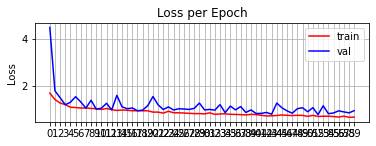

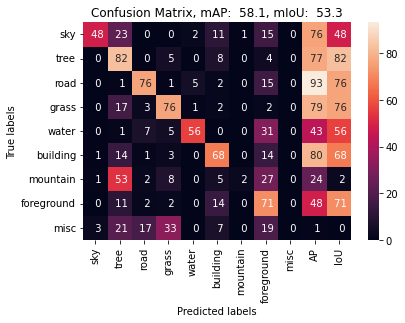

                 sky: AP: 0.76, IoU: 0.48
                tree: AP: 0.77, IoU: 0.82
                road: AP: 0.93, IoU: 0.76
               grass: AP: 0.79, IoU: 0.76
               water: AP: 0.43, IoU: 0.56
            building: AP: 0.80, IoU: 0.68
            mountain: AP: 0.24, IoU: 0.02
          foreground: AP: 0.48, IoU: 0.71
                misc: AP: 0.01, IoU: 0.00
                mean: AP: 0.58, IoU: 0.53


In [ ]:
model_unet = UNet().to(device)
lr = 0.001
optimizer = optim.AdamW(model_unet.parameters(), lr=lr, weight_decay=0.01)
training_loop(model=model_unet,
              optimizer=optimizer,
              trainloader=dataloader,
              device=device,
              criterion=cross_entropy_criterion,
              class_weights=class_weights,
              valloader=val_dataloader,
              epochs=60)

preds, gts = validate_model(val_loader=val_dataloader,
                            model=model_unet,
                            classes=classes,
                            device=device,
                            show_matrix=True)

Make sure to report the results for both models. 

## Working off a pretrained model (Q7)

Finally, you will now modify a pretrained model (resnet18) and use it as an initialization for training. You should be able to get better results with this model than before.

You can finetune (meaning backpropagate through the resnet layers) or not. You can finetune just some layers and not others. It's up to you.

**PDF: in your pdf report the final accuracy of your model based on a pretrained model. Describe how you used the pretrained model, which features did you extract and why?**

In [ ]:
class ResNetBackboneUNet(nn.Module):
    """
    In this implementation we will be swapping out the Encoder Backbone
    with a pretrained ResNet18
    """
    def __init__(self, num_classes=9):
        super(ResNetBackboneUNet, self).__init__()

        ### RESNET ENCODER ###
        pretrained_resnet = models.resnet18(pretrained=True)
        self.resnet_features = nn.Sequential(*list(pretrained_resnet.children())[:-2])

        ### DECODER ###
        self.features = [512,256,256,128,128,64]
        self.decoder = nn.ModuleList()

        for idx in range(len(self.features) - 1):
            self.decoder.append(
                nn.ModuleList([
                    nn.ConvTranspose2d(
                        ### TRANSPOSE FROM DOUBLE CHANNELS TO SINGLE
                        in_channels=self.features[idx],
                        out_channels=self.features[idx + 1],
                        kernel_size=(2, 2),
                        stride=(2, 2)),
                    ConvBlock(
                        ### DOUBLE CHANNELS FROM SKIP CAT
                        in_channels=self.features[idx + 1],
                        out_channels=self.features[idx + 1])
                ])
            )

        self.match_class_conv = nn.Conv2d(self.features[-1],
                                          out_channels=num_classes,
                                          kernel_size=(1, 1))
    def forward(self, x):
        ### RESNET ENCODE ###
        x = self.resnet_features(x)

        ### DECODER ###
        for idx, (transpose, block) in enumerate(self.decoder):
            x = transpose(x)
            x = block(x)

        ### OUTPUT TO NUM CLASSES ###
        x = self.match_class_conv(x)
        return x


  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch: 1, Training Loss: 1.970
Epoch: 1, Validation Loss: 2.339


0it [00:00, ?it/s]

Epoch: 2, Training Loss: 1.574
Epoch: 2, Validation Loss: 2.164


0it [00:00, ?it/s]

Epoch: 3, Training Loss: 1.336
Epoch: 3, Validation Loss: 1.522


0it [00:00, ?it/s]

Epoch: 4, Training Loss: 1.266
Epoch: 4, Validation Loss: 2.009


0it [00:00, ?it/s]

Epoch: 5, Training Loss: 1.141
Epoch: 5, Validation Loss: 1.605


0it [00:00, ?it/s]

Epoch: 6, Training Loss: 1.023
Epoch: 6, Validation Loss: 1.109


0it [00:00, ?it/s]

Epoch: 7, Training Loss: 0.962
Epoch: 7, Validation Loss: 1.143


0it [00:00, ?it/s]

Epoch: 8, Training Loss: 0.898
Epoch: 8, Validation Loss: 1.731


0it [00:00, ?it/s]

Epoch: 9, Training Loss: 0.947
Epoch: 9, Validation Loss: 1.279


0it [00:00, ?it/s]

Epoch: 10, Training Loss: 0.869
Epoch: 10, Validation Loss: 1.010


0it [00:00, ?it/s]

Epoch: 11, Training Loss: 0.844
Epoch: 11, Validation Loss: 1.113


0it [00:00, ?it/s]

Epoch: 12, Training Loss: 0.765
Epoch: 12, Validation Loss: 0.927


0it [00:00, ?it/s]

Epoch: 13, Training Loss: 0.774
Epoch: 13, Validation Loss: 0.976


0it [00:00, ?it/s]

Epoch: 14, Training Loss: 0.837
Epoch: 14, Validation Loss: 1.338


0it [00:00, ?it/s]

Epoch: 15, Training Loss: 0.775
Epoch: 15, Validation Loss: 1.130


0it [00:00, ?it/s]

Epoch: 16, Training Loss: 0.759
Epoch: 16, Validation Loss: 0.962


0it [00:00, ?it/s]

Epoch: 17, Training Loss: 0.773
Epoch: 17, Validation Loss: 1.037


0it [00:00, ?it/s]

Epoch: 18, Training Loss: 0.758
Epoch: 18, Validation Loss: 1.781


0it [00:00, ?it/s]

Epoch: 19, Training Loss: 0.775
Epoch: 19, Validation Loss: 1.046


0it [00:00, ?it/s]

Epoch: 20, Training Loss: 0.762
Epoch: 20, Validation Loss: 0.988


0it [00:00, ?it/s]

Epoch: 21, Training Loss: 0.726
Epoch: 21, Validation Loss: 0.915


0it [00:00, ?it/s]

Epoch: 22, Training Loss: 0.686
Epoch: 22, Validation Loss: 1.187


0it [00:00, ?it/s]

Epoch: 23, Training Loss: 0.691
Epoch: 23, Validation Loss: 0.859


0it [00:00, ?it/s]

Epoch: 24, Training Loss: 0.701
Epoch: 24, Validation Loss: 0.988


0it [00:00, ?it/s]

Epoch: 25, Training Loss: 0.650
Epoch: 25, Validation Loss: 1.010


0it [00:00, ?it/s]

Epoch: 26, Training Loss: 0.659
Epoch: 26, Validation Loss: 1.147


0it [00:00, ?it/s]

Epoch: 27, Training Loss: 0.662
Epoch: 27, Validation Loss: 0.814


0it [00:00, ?it/s]

Epoch: 28, Training Loss: 0.650
Epoch: 28, Validation Loss: 0.974


0it [00:00, ?it/s]

Epoch: 29, Training Loss: 0.649
Epoch: 29, Validation Loss: 0.872


0it [00:00, ?it/s]

Epoch: 30, Training Loss: 0.703
Epoch: 30, Validation Loss: 0.987


0it [00:00, ?it/s]

Epoch: 31, Training Loss: 0.640
Epoch: 31, Validation Loss: 0.835


0it [00:00, ?it/s]

Epoch: 32, Training Loss: 0.612
Epoch: 32, Validation Loss: 1.234


0it [00:00, ?it/s]

Epoch: 33, Training Loss: 0.628
Epoch: 33, Validation Loss: 0.972


0it [00:00, ?it/s]

Epoch: 34, Training Loss: 0.628
Epoch: 34, Validation Loss: 1.029


0it [00:00, ?it/s]

Epoch: 35, Training Loss: 0.604
Epoch: 35, Validation Loss: 1.005


0it [00:00, ?it/s]

Epoch: 36, Training Loss: 0.602
Epoch: 36, Validation Loss: 1.108


0it [00:00, ?it/s]

Epoch: 37, Training Loss: 0.585
Epoch: 37, Validation Loss: 0.884


0it [00:00, ?it/s]

Epoch: 38, Training Loss: 0.594
Epoch: 38, Validation Loss: 0.980


0it [00:00, ?it/s]

Epoch: 39, Training Loss: 0.554
Epoch: 39, Validation Loss: 0.776


0it [00:00, ?it/s]

Epoch: 40, Training Loss: 0.578
Epoch: 40, Validation Loss: 0.758


0it [00:00, ?it/s]

Epoch: 41, Training Loss: 0.566
Epoch: 41, Validation Loss: 0.887


0it [00:00, ?it/s]

Epoch: 42, Training Loss: 0.564
Epoch: 42, Validation Loss: 0.749


0it [00:00, ?it/s]

Epoch: 43, Training Loss: 0.545
Epoch: 43, Validation Loss: 0.760


0it [00:00, ?it/s]

Epoch: 44, Training Loss: 0.547
Epoch: 44, Validation Loss: 0.945


0it [00:00, ?it/s]

Epoch: 45, Training Loss: 0.558
Epoch: 45, Validation Loss: 0.802


0it [00:00, ?it/s]

Epoch: 46, Training Loss: 0.526
Epoch: 46, Validation Loss: 0.972


0it [00:00, ?it/s]

Epoch: 47, Training Loss: 0.525
Epoch: 47, Validation Loss: 0.741


0it [00:00, ?it/s]

Epoch: 48, Training Loss: 0.529
Epoch: 48, Validation Loss: 0.819


0it [00:00, ?it/s]

Epoch: 49, Training Loss: 0.561
Epoch: 49, Validation Loss: 0.790


0it [00:00, ?it/s]

Epoch: 50, Training Loss: 0.539
Epoch: 50, Validation Loss: 0.729


0it [00:00, ?it/s]

Epoch: 51, Training Loss: 0.524
Epoch: 51, Validation Loss: 0.885


0it [00:00, ?it/s]

Epoch: 52, Training Loss: 0.530
Epoch: 52, Validation Loss: 0.737


0it [00:00, ?it/s]

Epoch: 53, Training Loss: 0.501
Epoch: 53, Validation Loss: 0.692


0it [00:00, ?it/s]

Epoch: 54, Training Loss: 0.487
Epoch: 54, Validation Loss: 0.854


0it [00:00, ?it/s]

Epoch: 55, Training Loss: 0.472
Epoch: 55, Validation Loss: 0.752


0it [00:00, ?it/s]

Epoch: 56, Training Loss: 0.493
Epoch: 56, Validation Loss: 0.714


0it [00:00, ?it/s]

Epoch: 57, Training Loss: 0.504
Epoch: 57, Validation Loss: 1.153


0it [00:00, ?it/s]

Epoch: 58, Training Loss: 0.500
Epoch: 58, Validation Loss: 0.790


0it [00:00, ?it/s]

Epoch: 59, Training Loss: 0.517
Epoch: 59, Validation Loss: 1.027


0it [00:00, ?it/s]

Epoch: 60, Training Loss: 0.521
Epoch: 60, Validation Loss: 0.698


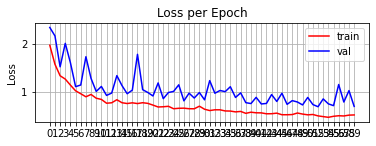

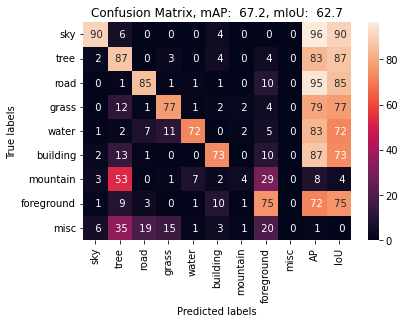

                 sky: AP: 0.96, IoU: 0.90
                tree: AP: 0.83, IoU: 0.87
                road: AP: 0.95, IoU: 0.85
               grass: AP: 0.79, IoU: 0.77
               water: AP: 0.83, IoU: 0.72
            building: AP: 0.87, IoU: 0.73
            mountain: AP: 0.08, IoU: 0.04
          foreground: AP: 0.72, IoU: 0.75
                misc: AP: 0.01, IoU: 0.00
                mean: AP: 0.67, IoU: 0.63


In [ ]:
model_resunet = ResNetBackboneUNet().to(device)
lr = 0.001
optimizer = optim.AdamW(model_resunet.parameters(), lr=lr, weight_decay=0.01)
training_loop(model=model_resunet,
              optimizer=optimizer,
              trainloader=dataloader,
              device=device,
              criterion=cross_entropy_criterion,
              class_weights=class_weights,
              valloader=val_dataloader,
              epochs=60)

preds, gts = validate_model(val_loader=val_dataloader,
                            model=model_resunet,
                            classes=classes,
                            device=device,
                            show_matrix=True)

# Test set

Finally we can check evaluation on test set....

**PDF: in your pdf report the results of your best model (this should be based on a pretrained model) on the test dataset.**

In [ ]:
test_dataset = SegmentationDataset(split="test", data_dir=DATASET_PATH, transform=False)
test_dataloader = data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, drop_last=False)

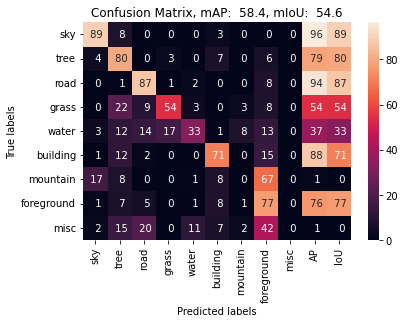

                 sky: AP: 0.96, IoU: 0.89
                tree: AP: 0.79, IoU: 0.80
                road: AP: 0.94, IoU: 0.87
               grass: AP: 0.54, IoU: 0.54
               water: AP: 0.37, IoU: 0.33
            building: AP: 0.88, IoU: 0.71
            mountain: AP: 0.01, IoU: 0.00
          foreground: AP: 0.76, IoU: 0.77
                misc: AP: 0.01, IoU: 0.00
                mean: AP: 0.58, IoU: 0.55


In [ ]:
preds, gts = validate_model(val_loader=test_dataloader,
                            model=model_resunet,
                            classes=classes,
                            device=device,
                            show_matrix=True)